In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
df = pd.read_csv("/kaggle/input/BNREEL_text.csv")
df

,file_id,class,text,source,category
0,1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie,Facebook,Safe
1,1006146964533997,Safe,[NULL],Facebook,Safe
2,1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love,Facebook,Unsafe
3,1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop,Facebook,Safe
4,1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং,Facebook,Safe
...,...,...,...,...,...
1916,3356285208118215619_62841927222,Safe,The amount of comfort this scene gives >>,Instagram,Safe
1917,3363424170779680862_62841927222_2,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1918,3363424170779680862_62841927222_3,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1919,3363424170779680862_62841927222_,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe


In [4]:
df = df[df['category']=='Unsafe']

In [5]:
df['class'], uniques = pd.factorize(df['class'])
uniques

<ipython-input-5-03e9cba94263>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'], uniques = pd.factorize(df['class'])


Index(['Adult', 'Harmful', 'Suicidal'], dtype='object')

In [8]:
dir1 = "/kaggle/input/Audio_V1/Audio_V1"
dir2 = "/kaggle/input/Audio_V2/Audio_V2"
dir3 = "/kaggle/input/UNBER_IG/UNBER_IG/Audio_IG"

In [9]:
pip install noisereduce --quiet

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import numpy as np
import pandas as pd
import librosa
import noisereduce as nr
import soundfile as sf

In [11]:
# def process_audio_for_vggish(file_path, target_window_duration=0.96, sample_rate=16000, 
#                              n_fft=400, hop_length=160, n_mels=64, expected_frames=96):
#     # Load and resample audio to 16kHz
#     audio, orig_sr = librosa.load(file_path, sr=None)
#     if orig_sr != sample_rate:
#         audio = resampy.resample(audio, orig_sr, sample_rate)

#     # Trim or pad to target duration (0.96 seconds for VGGish)
#     target_samples = int(target_window_duration * sample_rate)
#     if len(audio) > target_samples:
#         audio = audio[:target_samples]
#     else:
#         padding = target_samples - len(audio)
#         audio = np.pad(audio, (0, padding), mode='constant')

#     # Pre-emphasis (optional but common in audio preprocessing)
#     pre_emphasis = 0.96
#     audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

#     # Compute mel spectrogram
#     mel_spec = librosa.feature.melspectrogram(
#         y=audio,
#         sr=sample_rate,
#         n_fft=n_fft,
#         hop_length=hop_length,
#         n_mels=n_mels,
#         power=2.0
#     )

#     # Convert to log scale (dB)
#     log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

#     # Transpose to shape (frames, bins)
#     log_mel_spec = log_mel_spec.T  # Shape becomes (num_frames, 64)

#     # Ensure the shape is exactly (96, 64)
#     if log_mel_spec.shape[0] < expected_frames:
#         pad_width = expected_frames - log_mel_spec.shape[0]
#         log_mel_spec = np.pad(log_mel_spec, ((0, pad_width), (0, 0)), mode='constant')
#     elif log_mel_spec.shape[0] > expected_frames:
#         log_mel_spec = log_mel_spec[:expected_frames, :]

#     return log_mel_spec  # Final shape: (96, 64)

In [12]:
def load_audio_mono_16k(path, target_sr=16000):
    waveform, sr = librosa.load(path, sr=None, mono=True)
    if sr != target_sr:
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=target_sr)
    waveform = waveform.astype(np.float32)
    return waveform[:16000]  # Trim/pad to 1 second

In [13]:
X = []
y = []

In [14]:
for _, row in df.iterrows():
    reel_id = row["file_id"]
    label = row["class"]  

    for dir in list([dir1, dir2, dir3]):
        audio_file = os.path.join(dir, f"{reel_id}.wav")
        if os.path.exists(audio_file): 
            processed_audio = load_audio_mono_16k(audio_file)      
            X.append(processed_audio)
            y.append(label)

In [15]:
X = np.array(X, dtype=np.float32)

In [16]:
X.shape

(1056, 16000)

In [17]:
y = np.array(y)
y.shape

(1056,)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
import numpy as np

combined = list(zip(X_scaled, y))

np.random.shuffle(combined)

X, y = zip(*combined)

X = np.array(X)
y = np.array(y)

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [22]:
import tensorflow as tf
import tensorflow_hub as hub

# Load YAMNet
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet = hub.load(yamnet_model_handle)

In [23]:
def yamnet_feature_extractor(waveform, sample_rate=16000):
    # waveform: shape [n_samples] in float32, sampled at 16kHz
    # Returns embeddings and scores
    scores, embeddings, spectrogram = yamnet(waveform)
    return embeddings  # shape: [N, 1024]

In [24]:
def build_yamnet_transfer_model(input_length=16000, num_classes=1, dropout_rate=0.3):
    # Input: batch of 1D waveforms, shape (None, 16000)
    input_waveform = tf.keras.Input(shape=(input_length,), dtype=tf.float32)

    # Define a wrapper that works per sample
    def extract_embeddings_per_sample(waveform):
        _, embeddings, _ = yamnet(waveform)  # Each waveform -> [N, 1024]
        return embeddings  # shape: [N, 1024]

    # Map across batch
    embeddings = tf.keras.layers.Lambda(
        lambda x: tf.map_fn(
            extract_embeddings_per_sample,
            x,
            dtype=tf.float32,
            fn_output_signature=tf.TensorSpec(shape=(None, 1024), dtype=tf.float32)
        ),
        name="yamnet_embeddings"
    )(input_waveform)  # shape: (batch, N, 1024)

    # Average over time axis (N)
    x = tf.keras.layers.GlobalAveragePooling1D()(embeddings)  # shape: (batch, 1024)

    # Classifier head
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)

    return tf.keras.Model(inputs=input_waveform, outputs=output)

In [25]:
model = build_yamnet_transfer_model(input_length=16000, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ yamnet_embeddings (Lambda)           │ (None, 2, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,691 (260.51 KB)

 Trainable params: 66,691 (260.51 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [28]:
history = model.fit(
    X_train, y_train,  # training data
    epochs=50,  # number of epochs
    batch_size=16,  # batch size
    validation_data=(X_val, y_val),  # validation data
    callbacks=[early_stopping, lr_scheduler]  # early stopping
)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.4196 - loss: 1.0746 - val_accuracy: 0.4438 - val_loss: 1.0026 - learning_rate: 0.0010
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.4273 - loss: 1.0360 - val_accuracy: 0.4615 - val_loss: 0.9561 - learning_rate: 0.0010
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.4622 - loss: 1.0038 - val_accuracy: 0.5976 - val_loss: 0.8851 - learning_rate: 0.0010
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.5339 - loss: 0.9393 - val_accuracy: 0.5976 - val_loss: 0.8645 - learning_rate: 0.0010
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.6155 - loss: 0.8664 - val_accuracy: 0.5976 - val_loss: 0.8698 - learning_rate: 0.0010
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5966 - loss: 0.9022 - val_accuracy: 0.5621 - val_loss: 0.8693 - learning_rate: 0.0010
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.5876 - loss: 0.8564 -

In [29]:
y_pred = model.predict(X_test)
#y_pred_classes = (y_pred >= 0.5).astype(int)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


In [30]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.57      0.68      0.62        19
           1       0.67      0.31      0.42        13
           2       0.50      0.64      0.56        11

    accuracy                           0.56        43
   macro avg       0.58      0.54      0.53        43
weighted avg       0.58      0.56      0.54        43



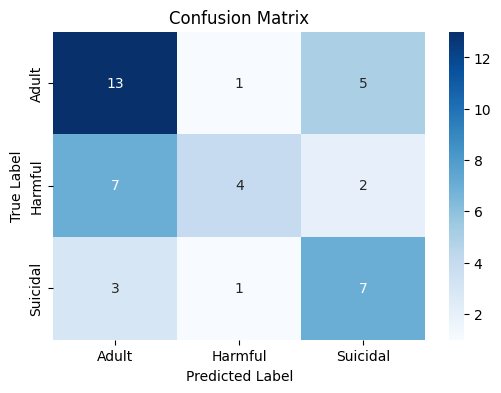

In [31]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Adult","Harmful", "Suicidal"], yticklabels=["Adult","Harmful", "Suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [32]:
# After training
model.save("yamnet_h2.keras")